# Bias & Variance Trade-off

This notebook will briefly cover the bias-variance trade-off using examples for regression (K Nearest Neighbors - KNN), and classification (Decision Trees - DT).

#### Install necessary libraries


In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install graphviz

#### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz

%matplotlib inline

## Regression

Here, we will generate some sample data, split the data into a training and testing set, use it to a train several KNN models with varying k values. 

KNN is a low-bias, non-parametric machine learning model. The model is trained to output a target value based on the average of its k nearest neighbors. Low values of k can cause the model to overfit to the data provided, and high values can cause the model to underfit. 

### Generate Sample Data

First, we will generate some sample data. We do this by randomly generating an X set, then using this X set with some function to generate y, and then adding noise to y.

In [3]:
## Generate some sample data
samples = 100

X = np.sort(5 * np.random.rand(samples,1), axis=0)
y_original = (np.sin(X) * np.cos(X)).reshape(samples,)
random_error = 0.5*(0.5 - np.random.rand(samples))
y = y_original + random_error

#### Plot datapoints
Here is a plot of the generated points

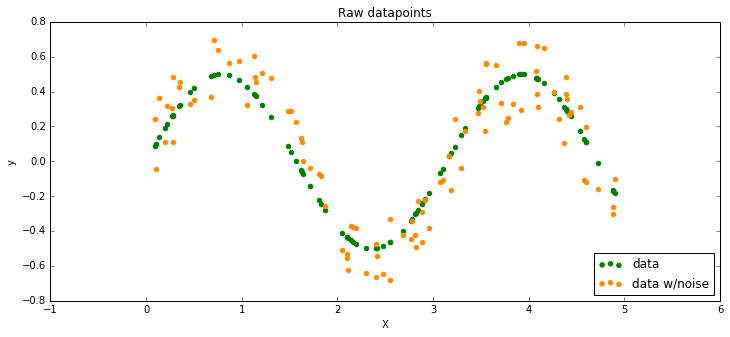

In [4]:
plt.figure(figsize=(12,5))
plt.xlabel('X')
plt.ylabel('y')
plt.title('Raw datapoints')
plt.scatter(X, y_original, color = 'green', label='data')
plt.scatter(X, y, color='darkorange', label='data w/noise')
plt.legend(loc=4)

The data with noise is what we will use as data for our model. 

### Split the data

We will now split the data into a training and testing set.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

X_train,y_train = zip(*sorted(zip(X_train,y_train)))
X_test,y_test = zip(*sorted(zip(X_test,y_test)))

### Train & Validate Several kNN models with Varying ks

Now we will train multiple kNN models with ks ranging from 1 to 50. We will plot the training predictions and testings predictions from the KNN models with k=1, k=3, k=10, k=30, and k=40 to see how the fit changes with increasing k.

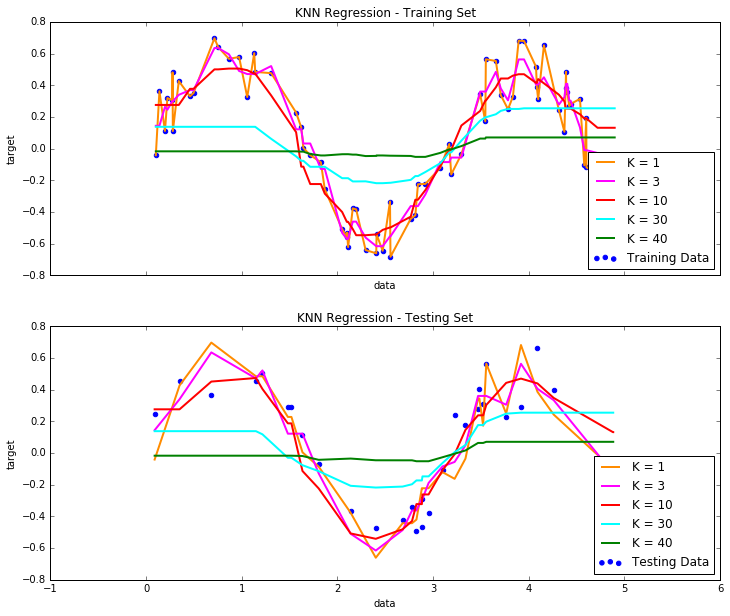

In [6]:
k_vals = 50 # max k value to check

lw = 2 # line width
colors = {1:'darkorange', 3:'magenta', 10: 'red', 30: 'cyan', 40: 'green'} # colors for plots

trainingERR = np.zeros(k_vals) # Array to store training errors
testingERR = np.zeros(k_vals) # Array to store testing errors
idx = 0 # index for above arrays

# Create subplots to show training and testing results for select models
f, (ax1,ax2) = plt.subplots(2,1,sharex=True, sharey=True, figsize=(12,10))
ax1.set_title('KNN Regression - Training Set')
ax2.set_title('KNN Regression - Testing Set')
ax1.set_xlabel('data')
ax1.set_ylabel('target')
ax2.set_xlabel('data')
ax2.set_ylabel('target')

# Plot the original data
ax1.scatter(X_train, y_train, color = 'blue', label='Training Data')
ax2.scatter(X_test, y_test, color = 'blue', label='Testing Data')

# Loop through all k values
for k in range(1,k_vals+1):
    # Initialize model
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Train
    knn.fit(X_train,y_train)
    
    # Predict    
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Calculate mean squared error of fit
    trainingERR[idx] = mean_squared_error(y_train, y_train_pred)
    testingERR[idx] = mean_squared_error(y_test, y_test_pred)
    
    idx+=1 # increment index
    
    # Plot select models
    if k in colors.keys():        
        ax1.plot(X_train,y_train_pred, lw=lw, color=colors[k], label="K = {}".format(k))
        ax2.plot(X_test, y_test_pred, lw=lw, color=colors[k], label="K = {}".format(k))

# Add legend to plots
ax1.legend(loc=4)
ax2.legend(loc=4)

From here, you can see that with k=10, the training line crosses through every datapoint, and the error is 0. This is an example of overfitting. The model has overfit to the training data so it can't generalize. It has a high variance, and a low bias. Inversely, by examining k = 40, we see a model that has underfit. The model barely follows the data, and has low variance, and a high bias. 

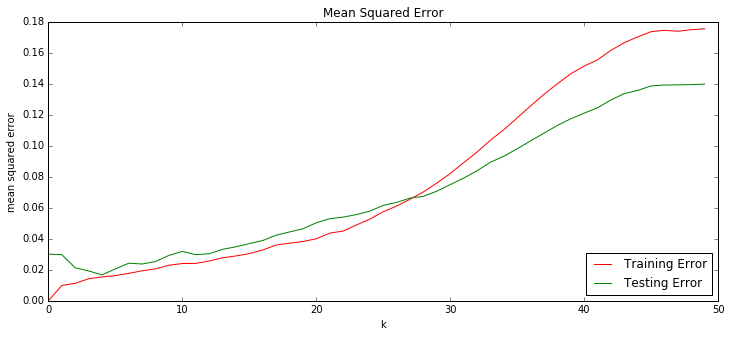

In [7]:
plt.figure(figsize=(12,5))
plt.plot(trainingERR,'r',label='Training Error')
plt.plot(testingERR,'g',label='Testing Error')

plt.title("Mean Squared Error")
plt.xlabel("k")
plt.ylabel("mean squared error")
plt.legend(loc=4)

From this plot, we see that the training error starts at 0 with k = 1, and grows slowly and then quickly with growing k. The testing error decreasings with increasing k prior to the increasing in proportion to the training error. The optimal model would have a similar training and testing error, as this shows the model is generalizable and performs similarly on the training and testing set. In our case, this should be around k = 3.

## Classification

For the classification example, we will use a dataset from the UCI repository: <html>https://archive.ics.uci.edu/ml/datasets/abalone</html>

We will create a categorical target variable to turn this problem into a classificaiton problem. We will then do 3-fold, 5-fold, and 10-fold cross validation with a decision tree with a max depth of 3 and see how the accuracy ranges change with increasing number of folds, then we will train multiple decision trees to see what impact the depth has on the accuracy and error of fit.

The Decision Tree is a low-bias, non-parametric machine learning model as well. The model is trained to find feature values to split on, and is limited in depth by the pre-set max-depth value. The tree can be visualized using the graphviz library. Low max depths can cause the model to underfit, and high max depths can cause the model to overfit.

### Read in data

We will first read in the data from abalone-data.csv. More information about the data structure can be found in abalone-names.txt.

In [8]:
df = pd.read_csv('abalone-data.csv', 
                 names=['sex','length','diameter','height',
                        'wholeWeight','shuckedWeight',
                        'visceraWeight','shellWeight','rings'])
df.head()

,sex,length,diameter,height,wholeWeight,shuckedWeight,visceraWeight,shellWeight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [9]:
df.describe()

,length,diameter,height,wholeWeight,shuckedWeight,visceraWeight,shellWeight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Above, we see that the rings range from 1-29. To turn this into a classification problem, we bin the rings in increment of 3 for the target usuing the below function. Using this new target variable, a classification algorithm will then attempt to predict which of the 10 classes a feature set belongs too.

In [10]:
def binTarget(x):
    if x <=  3: return 0
    if x <=  6: return 1 
    if x <=  9: return 2
    if x <= 12: return 3
    if x <= 15: return 4
    if x <= 18: return 5
    if x <= 21: return 6
    if x <= 24: return 7
    if x <= 27: return 8
    if x <= 30: return 9

In [11]:
df['target'] = df['rings'].apply(binTarget)
df.head()

,sex,length,diameter,height,wholeWeight,shuckedWeight,visceraWeight,shellWeight,rings,target
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,4
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,2
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,3
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,2


### Convert categorical data

Here we will hot encode the categorical column 'sex'. We will drop one of the generated dummy features as it is implied by the other 2, and drop the original feature.

In [12]:
dummies_sex = pd.get_dummies(df['sex'], prefix='sex')
df = pd.concat([df, dummies_sex], axis=1)
df = df.drop(['sex_I','sex'],axis=1)
df.head()

,length,diameter,height,wholeWeight,shuckedWeight,visceraWeight,shellWeight,rings,target,sex_F,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,4,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,2,1.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,3,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,2,0.0,0.0


### Plot learning curve

The below function can be used to plot the learning curve from sklearn.

In [13]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

### Split the data

Now we will split the data into two variables

In [14]:
X = df.drop(['target','rings'],axis=1)
y = df['target']

### KFold CV with varying ks
We will now perform 3-fold, 5-fold, and 10-fold cross validation with a decision tree with a max depth of 3.

In [15]:
trainACC = []
testACC = []

# Loop through requested folds
for folds in [3,5,10]:
    kfold = KFold(n_splits=folds)
    scaler = StandardScaler()
    kfold.get_n_splits(X)
    model = DecisionTreeClassifier(max_depth=3)
    
    # storage arrays
    train_acc = np.zeros(folds)
    test_acc = np.zeros(folds)
    np_idx = 0

    for train_idx, test_idx in kfold.split(X):
        # split data into training/testing sets
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        # Scale the data to a normal range
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # train the model
        model.fit(X_train, y_train)
        
        # make predictions
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        # update the storage arrays with the training and testing accuracies
        train_acc[np_idx] = accuracy_score(y_train, predictions_train)
        test_acc[np_idx] = accuracy_score(y_test, predictions_test)
        np_idx +=1
    
    trainACC.append(train_acc)
    testACC.append(test_acc)

### Visualize training/testings accuracies with a box plot

Below, we will generate 2 plots. One for training accuracies and one for testing accuracies. Each plot will have 3 box plots corresponding to the following kFold k values: 3, 5, and 10.

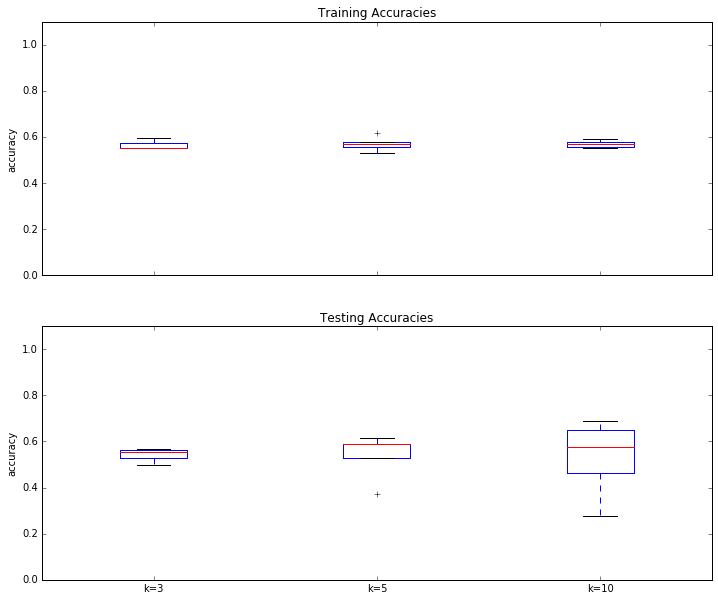

In [16]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True, sharey=True, figsize=(12,10))
ax1.set_title('Training Accuracies')
ax2.set_title('Testing Accuracies')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('accuracy')
ax1.set_ylim((0,1.1))
ax2.set_ylim((0,1.1))

ax1.boxplot(trainACC)
ax2.boxplot(testACC)

plt.setp((ax1,ax2), xticks=[1,2,3], xticklabels=['k=3','k=5','k=10'])



# data = [train_acc, test_acc]
# plt.figure()
# plt.boxplot(data)
# plt.ylim(0,1.2)
# plt.xticks([1,2],['Training','Testing'])

From, here we can see that with increasing k, the testing accuracy range increases. The lower the k value, the higher the bias, and the lower the variance. When k is equal to the number of samples, the error estimate is very low in high with the possibility of high variance.

### Learning curve

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

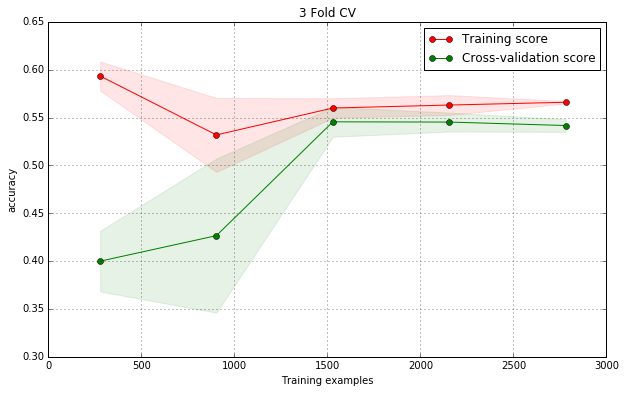

In [17]:
plot_learning_curve(DecisionTreeClassifier(max_depth=3), '3 Fold CV',X,y,cv=3)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

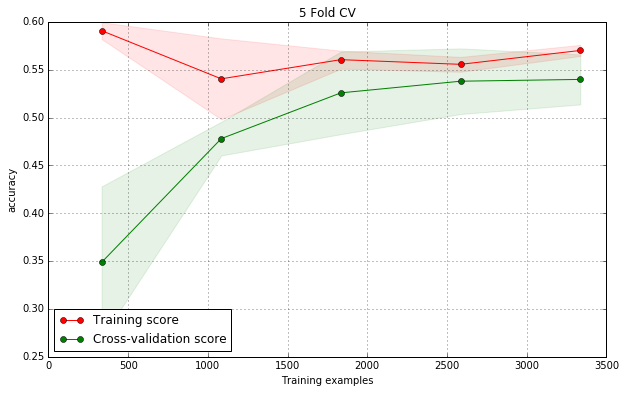

In [18]:
plot_learning_curve(DecisionTreeClassifier(max_depth=3), '5 Fold CV',X,y,cv=5)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


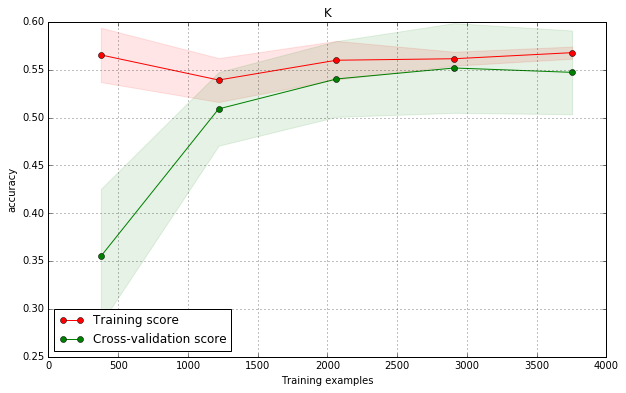

In [19]:
plot_learning_curve(DecisionTreeClassifier(max_depth=3), '10 Fold CV',X,y,cv=10)
plt.title('K')

Above we see that with lower folds, we the variance of cross-validation drops to 0 with enough training examples. The variance is fairly consistent for higher folds across varying training examples.

### Decision Trees with varying depths

Below we will split our dataset using train_test_split then train various decision trees with varying depths from 1 to 50.

In [20]:
depths = 50
trainACC = np.zeros(depths)
trainERR = np.zeros(depths)
testACC = np.zeros(depths)
testERR = np.zeros(depths)

idx = 0
folds = 10

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

for depth in range(1,depths+1):
    # initialize model
    model = DecisionTreeClassifier(max_depth=depth)
    
    # train model
    model.fit(X_train,y_train)
    
    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # store errors and accuracies
    trainACC[idx] = accuracy_score(y_train, y_train_pred)
    trainERR[idx] = mean_squared_error(y_train, y_train_pred)
    testACC[idx] = accuracy_score(y_test, y_test_pred)
    testERR[idx] = mean_squared_error(y_test, y_test_pred)
    idx += 1  

#### Plot accuracies and errors

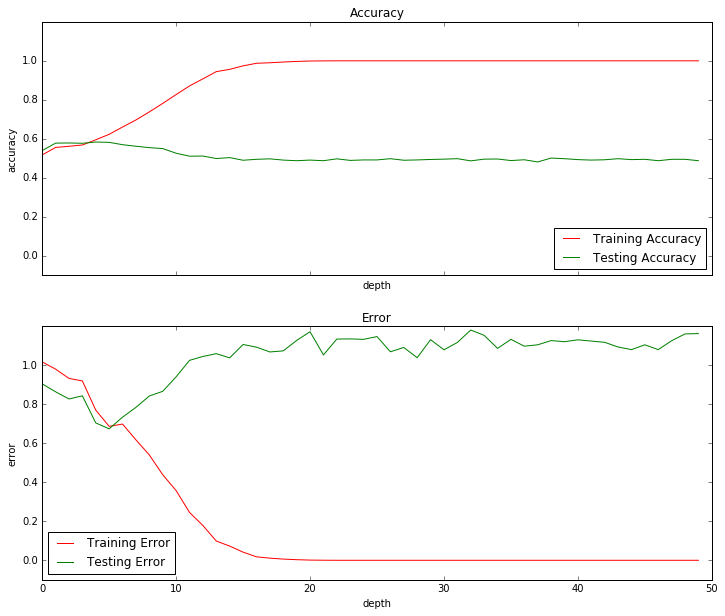

In [21]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True, sharey=True, figsize=(12,10))
ax1.set_title('Accuracy')
ax2.set_title('Error')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('error')
ax1.set_xlabel('depth')
ax2.set_xlabel('depth')

ax1.plot(trainACC,'r',label='Training Accuracy')
ax1.plot(testACC,'g',label='Testing Accuracy')
ax1.legend(loc=4)
ax1.set_ylim([0.2,1.1])

ax2.plot(trainERR,'r',label='Training Error')
ax2.plot(testERR,'g',label='Testing Error')
ax2.set_ylim([-0.1,1.2])
ax2.legend(loc=3)

Above, we see that the training accuracy starts low and proceeds to 100% with enough depth. This is because the tree is overfitting to the data. When the depth of the tree is too small, it is underfitting to the data, and has more accuracy in training. This is also evident in the error plot as the training error approaches 0 with increasing depth. Inversely, the testing accuracy increases then decreases, and the testing error decreases then increases. The optimal model would have a depth of roughly 5. As this is the point where the testing accuracy and error is similar to the te training accuracy and error.